In [10]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [11]:
path = Path("/workspaces/gorillatracker/data_vast/external-datasets/chimp_ctai_czoo/datasets_cropped_chimpanzee_faces")
path_ctai = path / "data_CTai"
path_czoo = path / "data_CZoo"

In [12]:
def parse_line(line):
    elements = line.strip().split()
    parsed_data = {}
    i = 0
    while i < len(elements):
        key = elements[i]
        value = elements[i + 1]
        if key in ["RightEye", "LeftEye", "MouthCenter", "LeftEarlobe", "RightEarlobe"]:
            value = (int(elements[i + 1]), int(elements[i + 2])) if elements[i + 1] != "Inf" else (-1, -1)
            i += 1
        elif value.isdigit():
            value = int(value)
        parsed_data[key] = value
        i += 2
    return parsed_data


def read_file_to_dataframe(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    data = []
    for line in lines:
        data.append(parse_line(line))

    return pd.DataFrame(data)


df_ctai = read_file_to_dataframe(path_ctai / "annotations_ctai.txt")
df_czoo = read_file_to_dataframe(path_czoo / "annotations_czoo.txt")
print(df_czoo.head())

                           Filename    Name  Age Age_Group  Gender  \
0  face_images/img-id1-object-1.png    Alex    9  Juvenile    Male   
1  face_images/img-id2-object-1.png    Alex    9  Juvenile    Male   
2  face_images/img-id3-object-1.png    Alex    9  Juvenile    Male   
3  face_images/img-id4-object-1.png  Jahaga   17     Adult  Female   
4  face_images/img-id5-object-1.png  Jahaga   17     Adult  Female   

     RightEye     LeftEye MouthCenter LeftEarlobe RightEarlobe  
0   (56, 260)  (118, 225)  (125, 434)  (270, 138)     (-1, -1)  
1   (53, 233)  (115, 184)  (109, 378)  (280, 122)     (-1, -1)  
2   (82, 198)  (166, 156)  (154, 341)  (318, 128)     (-1, -1)  
3  (159, 142)  (253, 149)  (199, 337)    (-1, -1)     (-1, -1)  
4  (166, 190)  (259, 199)  (186, 364)    (-1, -1)     (-1, -1)  


In [13]:
# remove rows with Name "Adult" because ambiguous
print(f"Removing {len(df_ctai[df_ctai['Name'] == 'Adult'])} rows from ctai")
print(f"Removing {len(df_czoo[df_czoo['Name'] == 'Adult'])} rows from czoo")
df_ctai = df_ctai[df_ctai["Name"] != "Adult"]
df_czoo = df_czoo[df_czoo["Name"] != "Adult"]

len(df_ctai), len(df_czoo)

Removing 416 rows from ctai
Removing 0 rows from czoo


(4662, 2109)

Number of unique individuals in ctai: 77
Number of unique individuals in czoo: 24


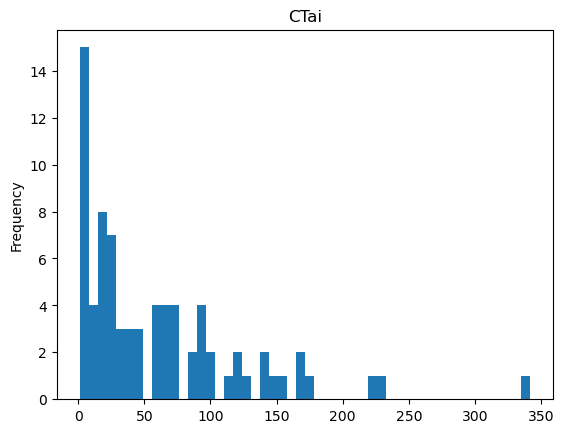

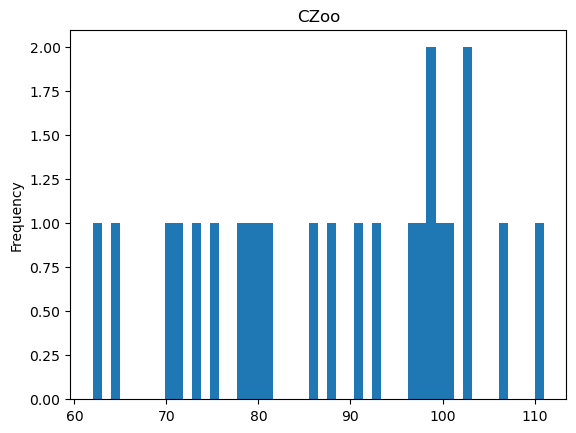

In [14]:
print(f"Number of unique individuals in ctai: {len(df_ctai['Name'].unique())}")
print(f"Number of unique individuals in czoo: {len(df_czoo['Name'].unique())}")

print("")


df_ctai.groupby("Name").size().plot(kind="hist", bins=50, title="CTai")
plt.show()
df_czoo.groupby("Name").size().plot(kind="hist", bins=50, title="CZoo")
plt.show()

In [5]:
from collections import defaultdict


def update_gender(df):  # NOTE: partially ambiguous gender labeling therefore we leave gender
    label_gender_dict = defaultdict(lambda: "Unknown")
    for index, row in df.iterrows():
        if row["Gender"] != "Unknown" and label_gender_dict[row["Name"]] == "Unknown":
            label_gender_dict[row["Name"]] = row["Gender"]
        if row["Gender"] != label_gender_dict[row["Name"]] and row["Gender"] != "Unknown":
            print(
                "Ambiguuos Gender for ", row["Name"], " with ", row["Gender"], " and ", label_gender_dict[row["Name"]]
            )


def check_consistency(df):
    df_label_set = {}
    for i, row in df.iterrows():
        vals = [row["Age"], row["Age_Group"], row["Gender"]]
        if row["Name"] not in df_label_set:
            df_label_set[row["Name"]] = vals
        else:
            if df_label_set[row["Name"]] != vals:
                print(f"Inconsistent values for {row['Name']}: {vals} vs {df_label_set[row['Name']]}")


# remove all columns except Name and Filename
# df_ctai = df_ctai[["Name", "Filename"]]
# df_czoo = df_czoo[["Name", "Filename"]]

In [6]:
# print unique values for Age_Group
print("CTAI")
print(df_ctai["Age_Group"].unique())

CTAI
['Adult' 'Infant' 'SubAdult' 'Juvenile' 'Unknown' 'Elderly']


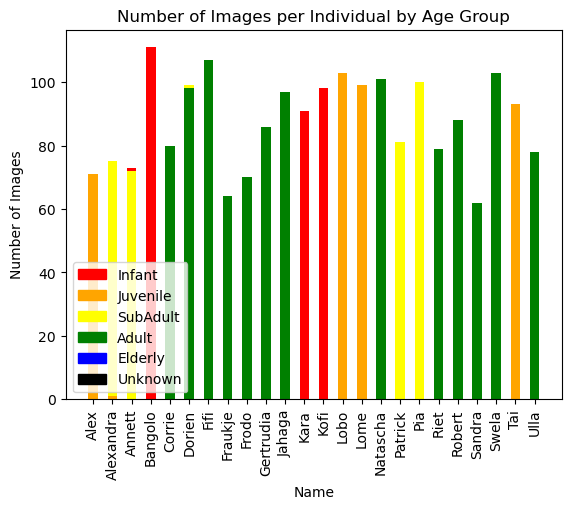

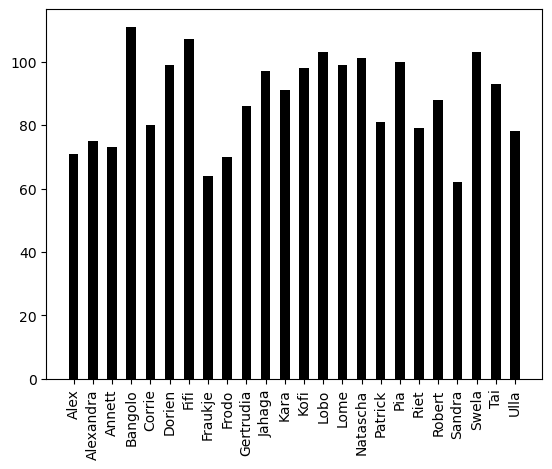

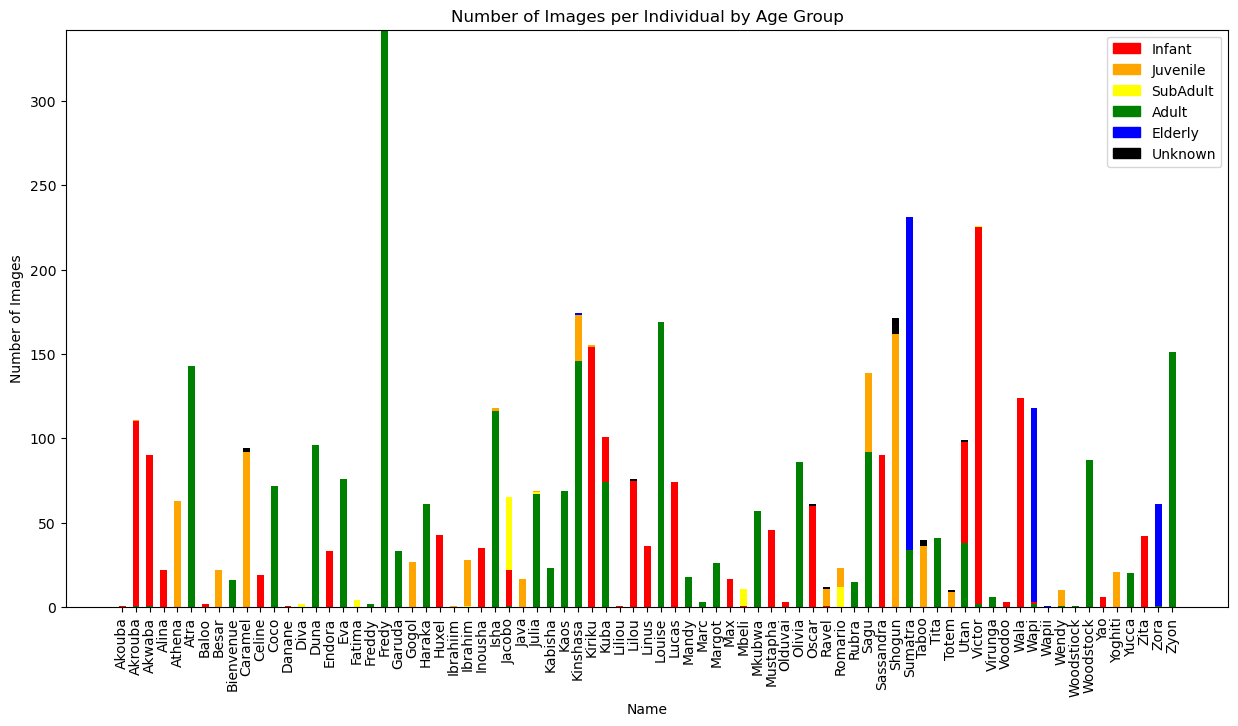

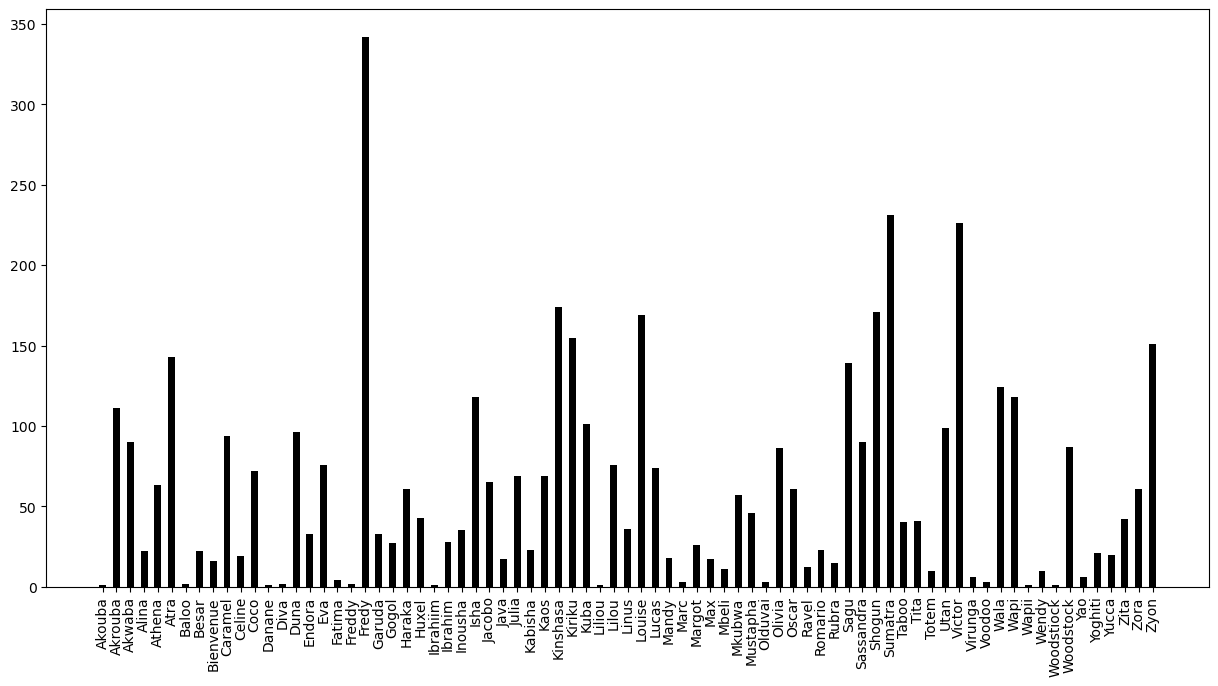

In [15]:
# make plot of the number of images per individual
# color the bar partially for the age group notation e.g. Adult, Infant, Juvenile, Subadult, Unknown
import matplotlib.patches as mpatches

age_group_colors = {
    "Infant": "red",
    "Juvenile": "orange",
    "SubAdult": "yellow",
    "Adult": "green",
    "Elderly": "blue",
    "Unknown": "black",
}


fig, ax = plt.subplots()
individuals = df_czoo["Name"].unique()
individuals.sort()
age_groups = df_czoo["Age_Group"].unique()

bottom = [0] * len(individuals)
for age_group in age_groups:
    age_group_counts = [
        len(df_czoo[(df_czoo["Name"] == name) & (df_czoo["Age_Group"] == age_group)]) for name in individuals
    ]
    ax.bar(
        individuals,
        age_group_counts,
        width=0.5,
        align="center",
        color=age_group_colors[age_group],
        bottom=bottom,
    )
    bottom = [sum(x) for x in zip(bottom, age_group_counts)]

ax.set_xlabel("Name")
ax.set_ylabel("Number of Images")
ax.set_title("Number of Images per Individual by Age Group")
plt.xticks(rotation=90)
mpatches_list = [mpatches.Patch(color=color, label=age_group) for age_group, color in age_group_colors.items()]
plt.legend(handles=mpatches_list)
plt.show()

fig, ax = plt.subplots()
plt.bar(
    individuals,
    [len(df_czoo[df_czoo["Name"] == name]) for name in individuals],
    width=0.5,
    align="center",
    color="black",
)
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7.5))
individuals = df_ctai["Name"].unique()
individuals.sort()
age_groups = df_ctai["Age_Group"].unique()

bottom = [0] * len(individuals)
for age_group in age_groups:
    age_group_counts = [
        len(df_ctai[(df_ctai["Name"] == name) & (df_ctai["Age_Group"] == age_group)]) for name in individuals
    ]
    ax.bar(
        individuals,
        age_group_counts,
        width=0.5,
        align="center",
        color=age_group_colors[age_group],
        bottom=bottom,
    )
    bottom = [sum(x) for x in zip(bottom, age_group_counts)]

ax.set_xlabel("Name")
ax.set_ylabel("Number of Images")
ax.set_title("Number of Images per Individual by Age Group")
plt.xticks(rotation=90)
# add the color legend
mpatches_list = [mpatches.Patch(color=color, label=age_group) for age_group, color in age_group_colors.items()]
plt.legend(handles=mpatches_list)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7.5))
plt.bar(
    individuals,
    [len(df_ctai[df_ctai["Name"] == name]) for name in individuals],
    width=0.5,
    align="center",
    color="black",
)
plt.xticks(rotation=90)
plt.show()

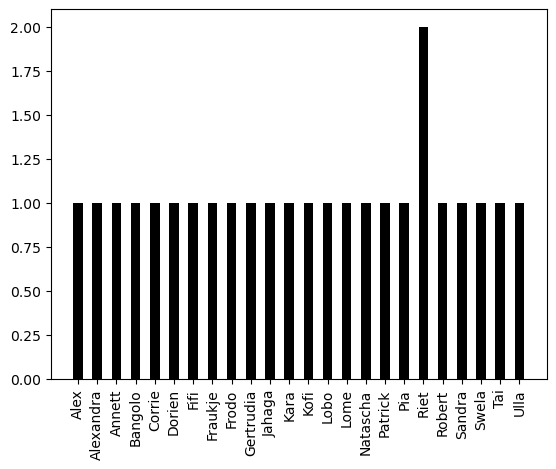

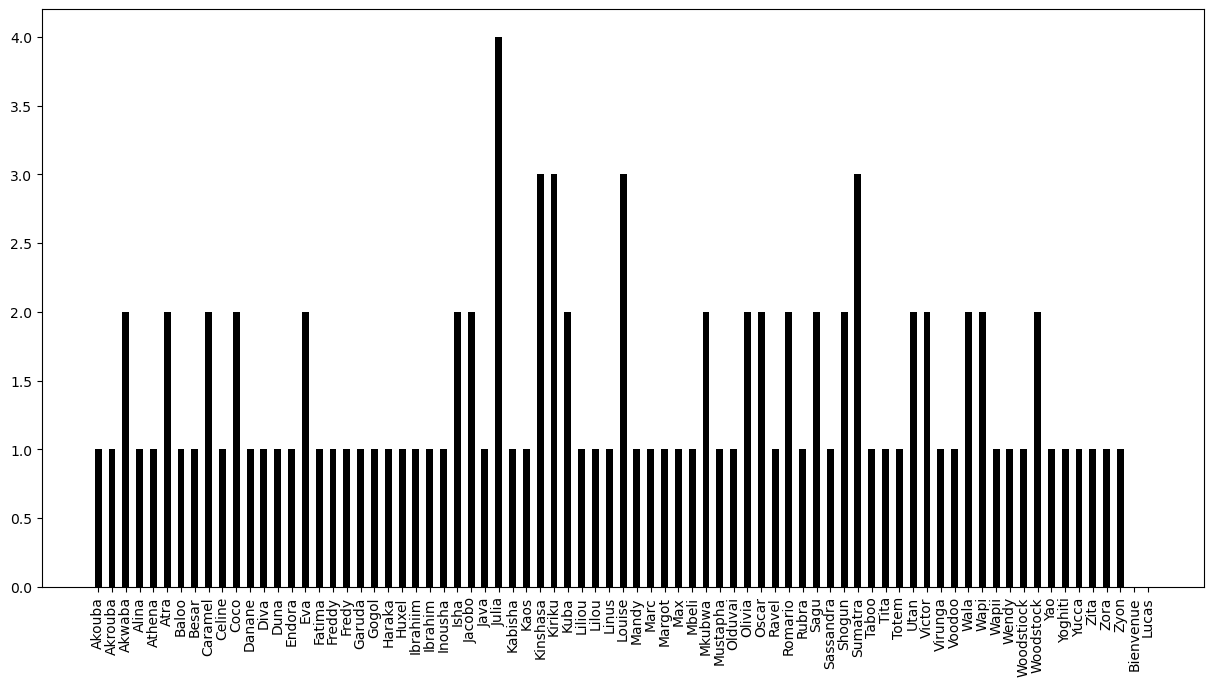

In [8]:
# plot the amount of different age entries per individual
fig, ax = plt.subplots()
individuals = df_czoo[df_czoo["Age"] != "NaN"]["Name"].unique()
individuals.sort()
ages_per_individual = df_czoo[df_czoo["Age"] != "NaN"].groupby("Name")["Age"].nunique()
individuals_nan = df_czoo[df_czoo["Age"] == "NaN"]["Name"].unique()
ages_per_individual_nan = [0] * len(individuals_nan)
individuals = list(individuals) + list(individuals_nan)
ages_per_individual = list(ages_per_individual) + ages_per_individual_nan
ax.bar(individuals, ages_per_individual, width=0.5, align="center", color="black")
plt.xticks(rotation=90)
plt.show()

# plot the amount of different age entries per individual
fig, ax = plt.subplots(figsize=(15, 7.5))
individuals = df_ctai[df_ctai["Age"] != "NaN"]["Name"].unique()
individuals.sort()

ages_per_individual = df_ctai[df_ctai["Age"] != "NaN"].groupby("Name")["Age"].nunique()
individuals_nan = df_ctai[df_ctai["Age"] == "NaN"]["Name"].unique()
ages_per_individual_nan = [0] * len(individuals_nan)
individuals = list(individuals) + list(individuals_nan)
ages_per_individual = list(ages_per_individual) + ages_per_individual_nan

ax.bar(individuals, ages_per_individual, width=0.5, align="center", color="black")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# load images for the chimp with the most swag
from PIL import Image

robert_images = df_ctai[df_ctai["Name"] == "Max"]["Filename"]
robert_images = robert_images.apply(lambda x: path_ctai / x)
robert_images = robert_images.tolist()

amount = 10
offset = 5
fig, ax = plt.subplots(1, amount, figsize=(20, 20))

assert len(robert_images) >= amount + offset
for i, img_path in enumerate(robert_images[offset : offset + amount]):
    img = Image.open(img_path)
    ax[i].imshow(img)
    ax[i].axis("off")

In [ ]:
# make directory containing all images prefixed with the name aka label
_TEST = False
czoo_dirpath = Path("/workspaces/gorillatracker/data_vast/external-datasets/chimp_ctai_czoo") / "czoo_format_adapted"
os.makedirs(czoo_dirpath, exist_ok=True)
for i, row in df_czoo.iterrows():
    img_path = path_czoo / row["Filename"]
    img = Image.open(img_path)
    img.save(czoo_dirpath / f"{row['Name']}_{Path(row['Filename']).name}")
    if _TEST:
        break

In [ ]:
!ls -l /workspaces/gorillatracker/data_vast/external-datasets/chimp_ctai_czoo/ctai_format_adapted | wc -l

In [ ]:
!ls -l /workspaces/gorillatracker/data_vast/external-datasets/chimp_ctai_czoo/czoo_format_adapted | wc -l